In [1]:
#Loading useful packages
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import scipy
from scipy import stats

from sklearn import preprocessing
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
path = "../data/AdSmartABdata.csv"
data=pd.read_csv(path)
data.tail()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
8073,ffea3210-2c3e-426f-a77d-0aa72e73b20f,control,7/3/2020,15.0,Generic Smartphone,6.0,Chrome Mobile,0.0,0.0
8074,ffeaa0f1-1d72-4ba9-afb4-314b3b00a7c7,control,7/4/2020,9.0,Generic Smartphone,6.0,Chrome Mobile,0.0,0.0
8075,ffeeed62-3f7c-4a6e-8ba7-95d303d40969,exposed,7/5/2020,15.0,Samsung SM-A515F,6.0,Samsung Internet,0.0,0.0
8076,fffbb9ff-568a-41a5-a0c3-6866592f80d8,control,7/10/2020,14.0,Samsung SM-G960F,6.0,Facebook,0.0,0.0
8077,>>>>>>> 46d2623a0f55fa7cc6e8ede17edef4b4ee8d4332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.isnull().sum()

auction_id     0
experiment     1
date           1
hour           1
device_make    1
platform_os    1
browser        1
yes            1
no             1
dtype: int64

In [4]:
data[data.isnull().any(axis=1)]

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
8077,>>>>>>> 46d2623a0f55fa7cc6e8ede17edef4b4ee8d4332,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
data=data.drop([8077])

<h2>Preparing data for machine learning</h2>

In [6]:
import datetime
data['date']=pd.to_datetime(data['date'])
data['day']=pd.Series(data['date'].dt.day_name())

#drop rows where both columns yes and no are 0
drop_rows=data[(data['yes']==0) & (data['no']==0)].index
data.drop(drop_rows,inplace=True)

#drop columns auction_id, no because that information is on column yes
data=data.drop(['auction_id','no','date'],axis=1)

In [7]:
browser=data.drop(['platform_os'],axis=1)
platform=data.drop(['browser'],axis=1)
#browser.reset_index()
#platform.reset_index()

**Create dummies for browser and  device columns**

In [8]:
browser=pd.get_dummies(data=browser,columns=['browser'])
browser.head()

,experiment,hour,device_make,yes,day,browser_Chrome,browser_Chrome Mobile,browser_Chrome Mobile WebView,browser_Chrome Mobile iOS,browser_Facebook,browser_Mobile Safari,browser_Mobile Safari UI/WKWebView,browser_Samsung Internet
2,exposed,2.0,E5823,0.0,Sunday,0,0,1,0,0,0,0,0
16,exposed,16.0,Generic Smartphone,1.0,Saturday,0,1,0,0,0,0,0,0
20,exposed,8.0,Generic Smartphone,0.0,Monday,0,1,0,0,0,0,0,0
23,control,4.0,Samsung SM-A202F,1.0,Wednesday,0,0,0,0,1,0,0,0
27,control,15.0,Generic Smartphone,0.0,Friday,0,1,0,0,0,0,0,0


In [9]:
platform=pd.get_dummies(data=platform,columns=['platform_os'])
platform.head()

,experiment,hour,device_make,yes,day,platform_os_5.0,platform_os_6.0
2,exposed,2.0,E5823,0.0,Sunday,0,1
16,exposed,16.0,Generic Smartphone,1.0,Saturday,0,1
20,exposed,8.0,Generic Smartphone,0.0,Monday,0,1
23,control,4.0,Samsung SM-A202F,1.0,Wednesday,0,1
27,control,15.0,Generic Smartphone,0.0,Friday,0,1


In [10]:
#Label Encoding to convert text columns to numerical format
from sklearn import preprocessing
le=preprocessing.LabelEncoder()

def label_en(df):
    columns=df.columns
    for i in columns:
        df[i]=le.fit_transform(df[i].astype(str))
        
label_en(browser)
label_en(platform)

In [11]:
platform.to_csv(r'C:\Users\user\OneDrive\Desktop\10Academy\abtest_mlops\data\platform.csv',header=True)
browser.to_csv(r'C:\Users\user\OneDrive\Desktop\10Academy\abtest_mlops\data\browser.csv',header=True)

<h2>Building the model</h2>

**Loss function**

In [12]:
def loss_function(y_test, y_preds):
    rmse = np.sqrt(mean_squared_error(y_test, y_preds))
    r_sq = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)

    print('Prediction RMSE Score: {}'.format(rmse))
    print('Prediction R2_Squared: {}'.format(r_sq))
    print('Prediction MAE Score: {}'.format(mae))

**Logistic Regression Model**

In [13]:
def log_model(X_train,X_test,y_train,y_test):
    kfold=KFold(n_splits=5,random_state=42,shuffle=True)
    model=LogisticRegression()
    #hyper-parameter tuning
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    print('Validation Accuracy: %.3f (%.3f)' %(np.mean(scores), np.std(scores)))
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    loss_function(y_test, y_pred)
    
    #get feature importance
    importance = model.coef_[0]
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    # plot feature importance
    sns.barplot([x for x in range(len(importance))], importance,palette='summer')
    plt.title('Logistic Regression Feature Importance')
    plt.show()

**Decision Trees**

In [14]:
def decision_trees(X_train,X_test,y_train,y_test):
    kfold=KFold(n_splits=5,random_state=42,shuffle=True)
    dtree=DecisionTreeClassifier()
    #hyper-parameter tuning
    scores = cross_val_score(dtree, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    print('Validation Accuracy: %.3f (%.3f)' %(np.mean(scores), np.std(scores)))
    dtree.fit(X_train,y_train)
    y_pred = dtree.predict(X_test)
    loss_function(y_test, y_pred)
    
    importance = dtree.feature_importances_
    # summarize feature importance
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))

    # plot feature importance
    sns.barplot([x for x in range(len(importance))], importance,palette='summer')
    plt.title('Decision Tree Classifier Feature Importance')
    plt.show()

**XGBoost**

In [15]:
def xgboost_model(X_train,X_test,y_train,y_test):
    kfold=KFold(n_splits=5,random_state=42,shuffle=True)
    model=XGBClassifier()
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=kfold, n_jobs=-1)
    print('Validation Accuracy: %.3f (%.3f)' %(np.mean(scores), np.std(scores)))
    model.fit(X_train,y_train)
    y_pred=model.predict(X_test)
    loss_function(y_test, y_pred)
    
    # Fit model using each importance as a threshold
    thresholds = np.sort(model.feature_importances_)
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier(verbosity=0)
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_test, predictions)
        print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))
        
    plot_importance(model,color='#B0C485')
    plt.show()

<h2>Browser Data</h2>

**Train-test-split**

In [24]:
df=browser

X=df.loc[:,df.columns != 'yes']
y=df['yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=42)  

Validation Accuracy: 0.525 (0.041)
Prediction RMSE Score: 0.6790625931104807
Prediction R2_Squared: -0.855721393034826
Prediction MAE Score: 0.46112600536193027
Feature: 0, Score: 0.07165
Feature: 1, Score: 0.00946
Feature: 2, Score: 0.00156
Feature: 3, Score: 0.00620
Feature: 4, Score: 0.28742
Feature: 5, Score: 0.14159
Feature: 6, Score: 0.29382
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.08026
Feature: 9, Score: -0.48328
Feature: 10, Score: -0.66202
Feature: 11, Score: -0.00014


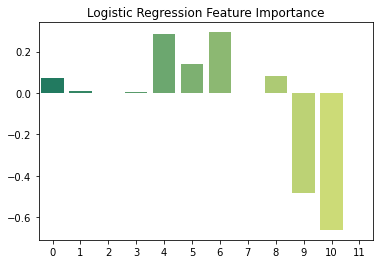

In [17]:
browser_log=log_model(X_train, X_test, y_train, y_test)
browser_log

Validation Accuracy: 0.507 (0.052)
Prediction RMSE Score: 0.698523912859439
Prediction R2_Squared: -0.9636121716996413
Prediction MAE Score: 0.4879356568364611
Feature: 0, Score: 0.09805
Feature: 1, Score: 0.21347
Feature: 2, Score: 0.29827
Feature: 3, Score: 0.26103
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.04569
Feature: 6, Score: 0.02572
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.04296
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.01480


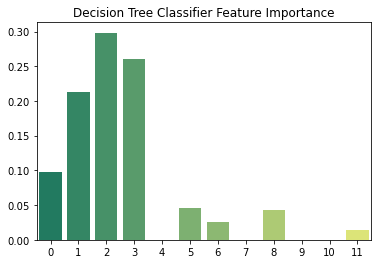

In [18]:
browser_tree=decision_trees(X_train, X_test, y_train, y_test)
browser_tree

Validation Accuracy: 0.499 (0.042)
[16:31:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Prediction RMSE Score: 0.6711200673293252
Prediction R2_Squared: -0.8125650815688996
Prediction MAE Score: 0.450402144772118
Thresh=0.000, n=12, Accuracy: 54.96%
Thresh=0.000, n=12, Accuracy: 54.96%
Thresh=0.000, n=12, Accuracy: 54.96%
Thresh=0.092, n=9, Accuracy: 54.96%
Thresh=0.093, n=8, Accuracy: 53.35%
Thresh=0.107, n=7, Accuracy: 50.94%
Thresh=0.108, n=6, Accuracy: 50.67%
Thresh=0.110, n=5, Accuracy: 51.74%
Thresh=0.118, n=4, Accuracy: 52.01%
Thresh=0.122, n=3, Accuracy: 51.47%
Thresh=0.122, n=2, Accuracy: 52.01%
Thresh=0.128, n=1, Accuracy: 49.60%


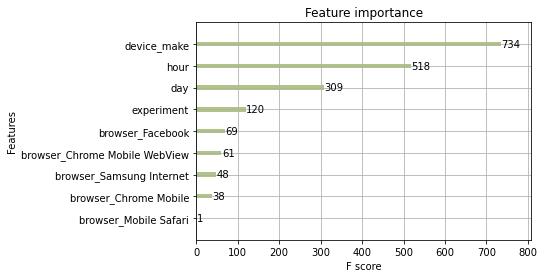

In [19]:
browser_xbg=xgboost_model(X_train, X_test, y_train, y_test)

Logistic Regression browser_Chrome','browser_Chrome Mobile', 'browser_Chrome Mobile WebView' 4,5,6  | 645
Decision Tree Classifier hour,device_make,day
xgboost device_make,hour,day

<h2>Platform data</h2>

In [28]:
df=platform

X=df.loc[:,df.columns != 'yes']
y=df['yes']
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.7,random_state=42)  

In [29]:
platform.columns

Index(['experiment', 'hour', 'device_make', 'yes', 'day', 'platform_os_5.0',
       'platform_os_6.0'],
      dtype='object')

Validation Accuracy: 0.521 (0.045)
Prediction RMSE Score: 0.6770856963593879
Prediction R2_Squared: -0.8449323151683443
Prediction MAE Score: 0.4584450402144772
Feature: 0, Score: 0.12771
Feature: 1, Score: 0.00966
Feature: 2, Score: 0.00142
Feature: 3, Score: 0.00695
Feature: 4, Score: -0.37604
Feature: 5, Score: 0.37624


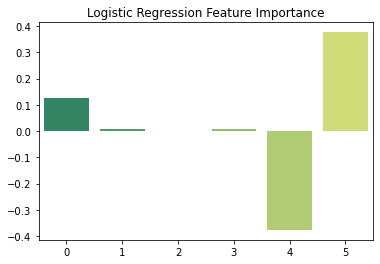

In [21]:
platform_log=log_model(X_train, X_test, y_train, y_test)
platform_log

Validation Accuracy: 0.500 (0.032)
Prediction RMSE Score: 0.690805179661132
Prediction R2_Squared: -0.9204558602337152
Prediction MAE Score: 0.4772117962466488
Feature: 0, Score: 0.10980
Feature: 1, Score: 0.23122
Feature: 2, Score: 0.33798
Feature: 3, Score: 0.31846
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00253


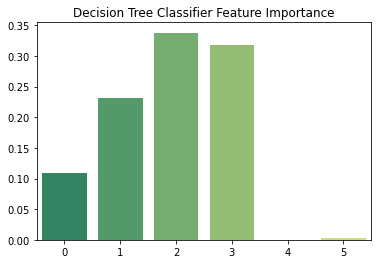

In [22]:
platform_tree=decision_trees(X_train, X_test, y_train, y_test)
platform_tree

Validation Accuracy: 0.498 (0.025)
Prediction RMSE Score: 0.6671133445503933
Prediction R2_Squared: -0.7909869258359365
Prediction MAE Score: 0.4450402144772118
Thresh=0.000, n=6, Accuracy: 55.50%
Thresh=0.000, n=6, Accuracy: 55.50%
Thresh=0.203, n=4, Accuracy: 55.50%
Thresh=0.258, n=3, Accuracy: 54.42%
Thresh=0.262, n=2, Accuracy: 55.23%
Thresh=0.277, n=1, Accuracy: 49.60%


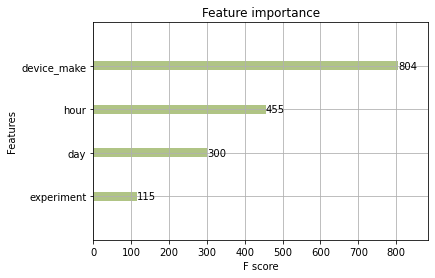

In [23]:
platform_xdg=xgboost_model(X_train, X_test, y_train, y_test)
platform_xdg